In [1]:
from customer_analyzer import CustomerAnalyzer
ca=CustomerAnalyzer(f"mssql+pyodbc://localhost/AdventureWorks2022?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&TrustServerCertificate=yes")

# Customer Analysis

### Fictitious scenario

The higher-ups at Adventureworks have a firm beleif in nurturing existing customer relations and in creating a steady flow of new customers. This philosophy applies not only to the big store customers but to private individual customers as well. 

As a consequence, a decision has been made to target 500 existing most valued private individual US-customers and give them a no strings attached, one-time, one-product, but any product 40 % discount. The same is to be done for 500 individuals in the general US-population. At lower levels in the organization, especially among the business analysts, this decision has sparked a discussion about whether it is at all possible to implement this decision in such a way that we can expect to actually make money on the sales with these discounted prices. 

A junior analyst decides to answer this question using a data driven approach where a market segmentation, based on available demographic data, is performed and an investigation of whether there are market segments, where Adventureworks can expect to be profitable even at these highly discounted prices.

### Executive summary

The goal of this analaysis is to find at least one segment of the US, private individual market that is profitable even at an across the board 40% discount rate. To this end, we segment this market based on available demographic data in the existing customer data base. These demographics are as follows:

1. Age
2. Marital Status (Single/Married)
3. Education Level
4. Income Level
5. Gender
6. Whether the person is a home owner
7. Whether the person is a car owner
8. Whether the peson has children in the household

We then proceed to calculate two quantities:

1. The average profit within each segment
2. The ratio of sales, whithin each segment, where the customer has stated that the reason for the sale was either "Price" or "Promotion"

Since the explicitly stated purpose of the discount is to show customer appreciation and to attract new customers, we require the second quantity to be rather high, at least 0.8 at the 95% confidence level, so that we can be relatively confident that those targeted will have good use for the discount. 

It turns out that with these restrictions applied, there is exactly one segment, consisting of 508 customers, that has a positive average profit at the 95% confidence level: Above age 50, married, high education, high income men who own a home and a car, and who have children in the household. We recommend that this segment should be targeted for the discount. Below are the top five segments, ordered by their average profit lower bound, with the discount taken into account. 

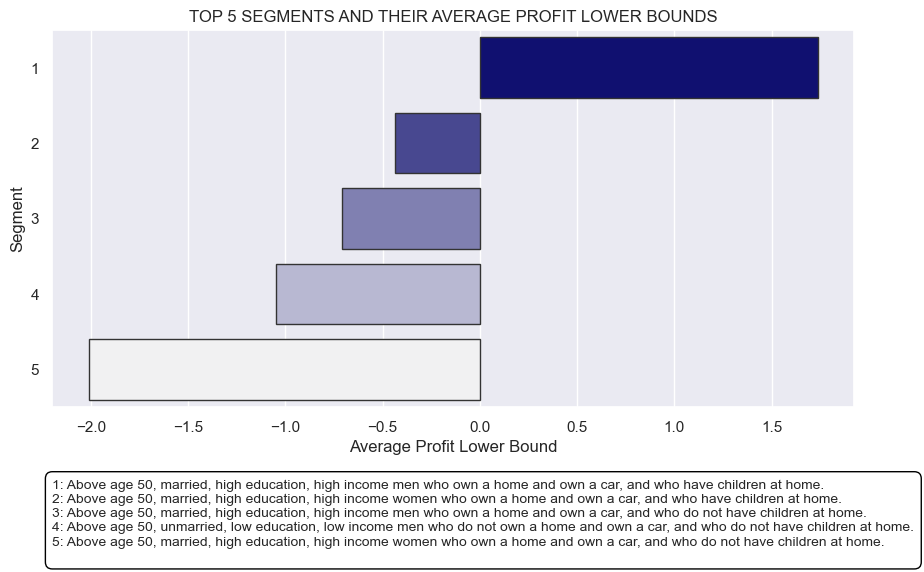

In [2]:
ca.plot_top_five_segments()

Below are the top 5 selling products in the targeted segment and their respective average profits and sales volumes.

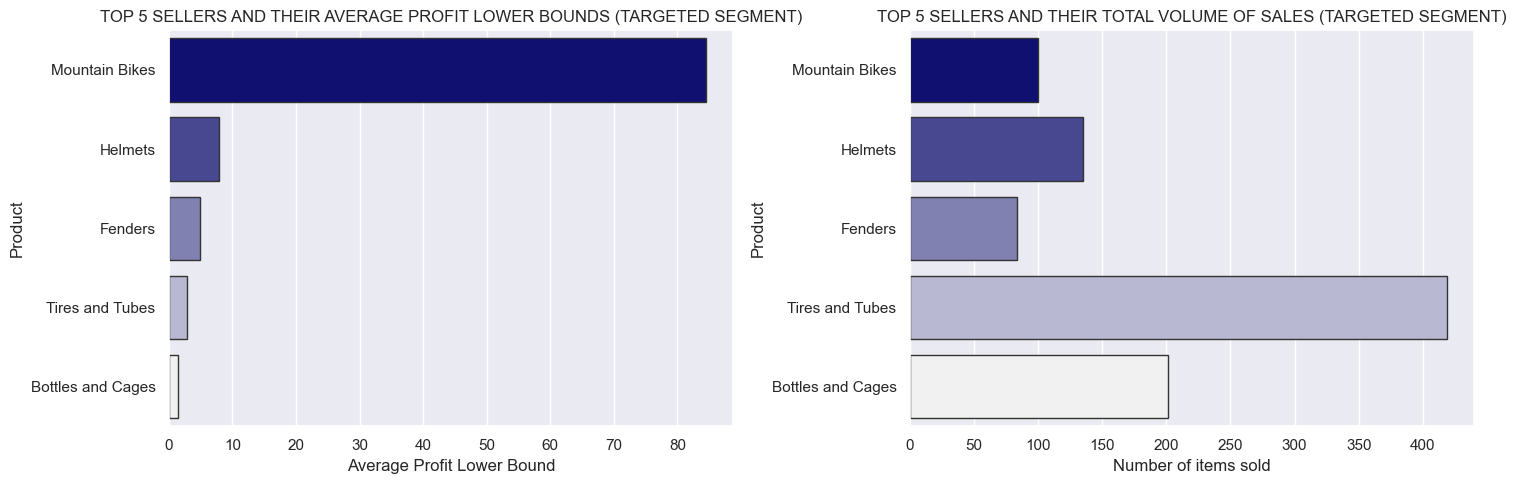

In [3]:
ca.plot_top_five_products('01000111')

Although we refrain from doing so here, further profit optimization could be made by only targeting specific products for the discount.

### Detailed analysis

We begin by performing the segmentation. Using the Sales.Customers and Person.Person tables, we may construct the following dataframe of binary demographics data for US private individual customers:

In [4]:
print(f'Number of rows: {ca.demogr_df.shape[0]}')
ca.demogr_df.head()

Number of rows: 7819


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome
0,19530,2432,0,0,0,0,1,1,1,0
1,19238,2457,0,1,0,1,1,1,0,0
2,11891,2460,0,1,0,0,1,1,1,1
3,13895,2461,0,0,0,0,1,1,0,0
4,15155,2463,0,1,0,0,1,1,1,0


We are going to need some form of measure of responsiveness to price and promotion within each market segment. Using the tables Sales.SalesOrderHeader and Sales.Sales.OrderHeaderSalesReason, we construct a binary variable SalesReasonIDIsAppropriate which takes the value 1 if one of the reasons for the sale was "Price" or "Promotion" and 0 otherwise. We can use this variable to define the responsiveness measure as the ratio of orders within each segment where one of the reasons for the sale was "Price" or "Promotion". The updated dataframe looks like this: 

In [5]:
print(f'Number of rows: {ca.demordsreason_df.shape[0]}')
ca.demordsreason_df.head()

Number of rows: 9567


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome,SalesOrderID,OrderDate,SalesReasonIDIsAppropriate
0,19530,2432,0,0,0,0,1,1,1,0,53341,2013-07-28,0
1,19238,2457,0,1,0,1,1,1,0,0,57918,2013-10-13,0
2,11891,2460,0,1,0,0,1,1,1,1,54019,2013-08-07,1
3,11891,2460,0,1,0,0,1,1,1,1,61280,2013-11-30,0
4,13895,2461,0,0,0,0,1,1,0,0,49739,2013-02-17,0


We see now that the number of rows has increased, which is natural since one customer can have many orders. We will also need a measure of profitability within each segment. To construct such a measure, we need detailed data about the contents of the order such as order quantities, product ids and prices. This information can be found in the Sales.SalesOrderDetail table. The updated dataframe has the following appearance: 

In [6]:
print(f'Number of rows: {ca.demordsreasonorddet_df.shape[0]}')
ca.demordsreasonorddet_df.head()

Number of rows: 21344


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome,SalesOrderID,OrderDate,SalesReasonIDIsAppropriate,SalesOrderDetailID,OrderQty,ProductID,UnitPrice,UnitPriceDiscount,LineTotal
0,19530,2432,0,0,0,0,1,1,1,0,53341,2013-07-28,0,46474,1,798,1120.49,0.0,1120.49
1,19238,2457,0,1,0,1,1,1,0,0,57918,2013-10-13,0,65007,1,869,69.99,0.0,69.99
2,11891,2460,0,1,0,0,1,1,1,1,54019,2013-08-07,1,51446,1,930,35.00,0.0,35.00
3,11891,2460,0,1,0,0,1,1,1,1,54019,2013-08-07,1,51447,1,921,4.99,0.0,4.99
4,11891,2460,0,1,0,0,1,1,1,1,54019,2013-08-07,1,51448,1,711,34.99,0.0,34.99


It is important to investigate the contents of the OrderQty and UnitPrice columns since these will affect how we calculate the profits. The minimum and maximum values of these are shown below

In [7]:
print(f'OrderQty minimum: {ca.demordsreasonorddet_df.OrderQty.min()}')
print(f'OrderQty maximum: {ca.demordsreasonorddet_df.OrderQty.min()}')
print(f'UnitPriceDiscount minimum: {ca.demordsreasonorddet_df.UnitPriceDiscount.min()}')
print(f'UnitPriceDiscount maximum: {ca.demordsreasonorddet_df.UnitPriceDiscount.max()}')

OrderQty minimum: 1
OrderQty maximum: 1
UnitPriceDiscount minimum: 0.0
UnitPriceDiscount maximum: 0.0


It turns out that these columns both have constant values and so we don't need to take them into account. We need one more piece of data to be able to perform the analysis: The cost of each product. This information is available in the Production.Product table via the StandardCost column. We add this column to our dataframe. Then we define the measure AdjustedProfit as 0.6 * LineTotal - StandardCost. This measure takes into account the 40% discount. We compress the demographics column into a single column using concatenation to form a segment label and remove columns we don't need. The final dataframe (sorted on labels) containing the data we need now looks as follows:

In [8]:
print(f'Number of rows: {ca.data_df.shape[0]}')
ca.data_df.head()

Number of rows: 21344


,Label,CustomerID,SalesOrderID,SalesOrderDetailID,ProductID,SalesReasonIDIsAppropriate,AdjustedProfit
0,00000000,14726,45227,5678,760,0,-67.24768
1,00000000,21720,53029,45698,870,1,1.12770
2,00000000,13713,73562,117614,871,1,2.25770
3,00000000,27202,54115,51686,923,1,1.12770
4,00000000,28662,61843,78562,923,1,1.12770


As can be seen, the number of rows has not changed, which is as it should be. We also note that there are rows with a negative profit. These are rows where the product sold is such that we actually loose money by giving a 40% reduction in price. We want to examine if there are any segments, where we can expect to make money even with the 40% reduction in price. This examination is performed as follows:

1. Calculate the average adjusted profit within each segment
2. Calculate the ratio of products where one of the reasons for the sale was "Price" or "Promotion" (the SegmentPricePromotionSensitivity column in the dataframe below)
3. Calculate lower bounds for these variables at the 95% confidence level.

We require there to be at least 50 customers (and thereby at least as many orders) in the segment to ensure central limit theorem applicability for the calculation of lower bounds. Also, we want our chosen customers to actually use the discount, because only then, can we be relatively certain that the "softer" intentions of the discount, such as the customer feeling appreciated, will be achieved. We therefore require the PricePromotionSensitivity lower bound to be at least 0.8.

With these calculations and requirements, the aggregated data is shown below:


In [9]:
ca.aggregated_data_df

,Label,SegmentNumDistinctCustomers,SegmentNumDistinctOrders,SegmentNumOrderDetail,SegmentNumDestinctProducts,SegmentAverageSalesReasonIDIsAppropriate,SegmentAverageAdjustedProfit,AverageSalesReasonIDIsAppropriateCILowerBound,AverageAdjustedProfitCILowerBound
0,01000111,508,618,1365,104,0.856410,5.704049,0.819190,1.737305
1,01001111,434,552,1239,109,0.858757,4.496859,0.819956,-0.437910
2,01000110,361,449,1040,111,0.850000,4.565191,0.806576,-0.708569
3,00110010,60,62,137,30,0.934307,3.314636,0.851030,-1.047713
4,01001110,400,494,1131,116,0.846154,2.577934,0.804080,-2.010171
5,01111010,52,55,117,44,0.931624,1.137117,0.839763,-3.571067
6,01110111,52,57,127,39,0.913386,1.550641,0.815161,-4.178197
7,01000101,113,136,314,71,0.885350,-0.464872,0.814758,-7.918840
8,11111110,67,80,185,51,0.891892,0.429471,0.802157,-8.595453
9,10110110,54,60,136,40,0.926471,3.317570,0.838413,-9.436777


As can be seen, there are several segments for which the calculated average adjusted profit is positive, but only one segment for which the lower bound at the 95% confidence level is positive. This is the segment we should target. What type of customer belongs to this segment? The answer is shown below.

In [10]:
ca.label_to_description('01000111')

'Above age 50, married, high education, high income men who own a home and own a car, and who have children at home.'

To those who have, more shall be given, it would seem. What products then, should we expect to sell to this "alpha male" segment?

In [11]:
ca.get_top_products('01000111')

,ProductSubCategoryName,NumSold,AvgAdjProfit,AverageAdjustedProfitCILowerBound
0,Tires and Tubes,419,3.459537,2.887506
1,Bottles and Cages,201,1.559461,1.412755
2,Helmets,135,7.907700,7.907700
3,Road Bikes,114,-46.839325,-66.884374
4,Mountain Bikes,100,102.116896,84.506073
5,Fenders,84,4.967500,4.967500
6,Jerseys,77,-8.798560,-8.950394


We see that tires and tubes are the top sellers. We also note that among these top sellers there are products with 